# How to automate LiDAR point cloud sub-sampling with Python

# Step 1 : Setting up the environment 

# Step 2: Load and prepare the data

In [1]:
pip install laspy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#libraries used
import numpy as np
import pandas as pd
import laspy as lp  # reads las pointcloud file 
import open3d as o3d # visualize file   



# Reference Code
# https://colab.research.google.com/drive/1addhGqN3ZE1mIn4L6jQnnkVs7_y__qSE?usp=sharing

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#create paths and load data

#Load the file
dataname="Tile (49).las"
point_cloud = lp.read(dataname)


In [4]:
# examine the avaliable features for the lidar file we have reead
list(point_cloud.point_format.dimension_names)


['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue']

In [5]:
set(list(point_cloud.classification))

{0}

In [6]:
# preperatin for visualization 
#Creating, filtering, and writing Point cloud data : Version 1
#store coordinates in "points", and colors in "colors" variable
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()


In [7]:
#Creating, filtering, and writing Point cloud data : Version 2
# To create 3D point cloud data, we can stack together with the X, Y, Z dimensions using numpy

point_data = np.stack([point_cloud.X,point_cloud.Y,point_cloud.Z], axis = 0).transpose((1,0))

In [8]:
# 3D Point Cloud Visualization 
# Laspy has no visualizationm methods so that we wil use the open3d library, we first create
# the open34D geometries and pass the point data we have created. Finally we use the 
# open3D visualization to draw geometries. 

geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

# Step 3: Choose a sub-sampling strategy

In [9]:
# 1 Point Cloud Decimation

In [10]:
#The decimation strategy, by setting a decimation factor
factor=160
decimated_points = points[::factor]
decimated_colors = colors[::factor]
len(decimated_points)

28241

In [11]:
# 2 Point Cloud voxel grid

In [12]:
# Initialize the number of voxels to create to fill the space including every point
voxel_size=7
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
#nb_vox.astype(int) #this gives you the number of voxels per axis

In [13]:
# Compute the non empty voxels and keep a trace of indexes that we can relate to points in order to store points later on.
# Also Sum and count the points in each voxel.
non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
#len(non_empty_voxel_keys) # if you need to display how many no-empty voxels you have

In [14]:
#Here, we loop over non_empty_voxel_keys numpy array to
#       > Store voxel indices as keys in a dictionnary
#       > Store the related points as the value of each key
#       > Compute each voxel barycenter and add it to a list
#       > Compute each voxel closest point to the barycenter and add it to a list

voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0

for idx,vox in enumerate(non_empty_voxel_keys):
  voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
  grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
  grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
  last_seen+=nb_pts_per_voxel[idx]

# Step 4: Vizualise and export the results

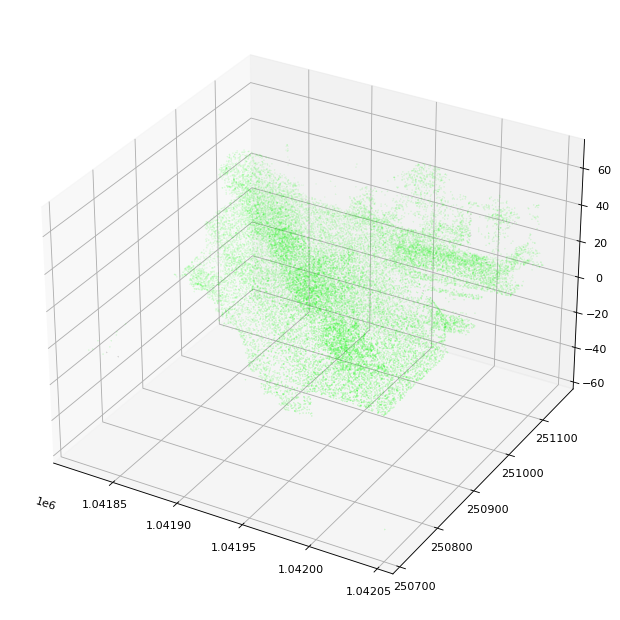

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

ax = plt.axes(projection='3d')
ax.scatter(decimated_points[:,0], decimated_points[:,1], decimated_points[:,2], c = decimated_colors/65535, s=0.01)
plt.show()

In [16]:
#output_path = 
# %timeit np.savetxt(output_path+dataname+"_voxel-best_point_%s.xyz" % (voxel_size), grid_candidate_center, delimiter=";", fmt="%s")

In [17]:
# Load data
import open3d as o3d
import laspy as lp

dataname="Tile (49).las"
point_cloud =  lp.read(dataname)

pcd = o3d.geometry.PointCloud()

pcd.paint_uniform_color([1, 0.5, 0.7])

pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors/65535)
# pcd.normals = o3d.utility.Vector3dVector(normals)
o3d.visualization.draw_geometries([pcd])

# Step 5 : Automate with functions

In [18]:
#Define a function that takes as input an array of points, and a voxel size expressed in meters. It returns the sampled point cloud
def grid_subsampling(points, voxel_size):

  nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
  non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
  idx_pts_vox_sorted=np.argsort(inverse)
  voxel_grid={}
  grid_barycenter,grid_candidate_center=[],[]
  last_seen=0

  for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

  return grid_candidate_center

In [19]:
#Execute the function, and store the results in the grid_sampled_point_cloud variable
# grid_sampled_point_cloud = grid_subsampling(point_cloud, 6)

#Save the variable to an ASCII file to open in a 3D Software
# %timeit np.savetxt(output_path+dataname+"_sampled.xyz", grid_sampled_point_cloud variable, delimiter=";", fmt="%s")

In [20]:
import open3d as o3d
import numpy as np

def roty(t):
    """
    Rotation about the y-axis.
    """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, 0, s],
                     [0, 1, 0],
                     [-s, 0, c]])


def box_center_to_corner(box):
        
    translation = box[3:6]
    h, w, l = box[0], box[1], box[2]
    #if the angle value is in radian then use below mentioned conversion
    # rotation_y = box[6]
    # rotation = rotation_y * (180/math.pi)                             #rad to degree
    rotation = box[6]

    # Create a bounding box outline if x,y,z is center point then use defination bounding_box as mentioned below
    # bounding_box = np.array([
    #     [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
    #     [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
    #     [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]])
    
    # Create a bounding box outline if x,y,z is rear center point then use defination bounding_box as mentioned below
    bounding_box = np.array([
                [l,l,0,0,l,l,0,0],                      
                [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2],          
                [0,0,0,0,h,h,h,h]])                        

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), -np.sin(rotation), 0.0],
        [np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])

    # Standard 3x3 rotation matrix around the X axis
    # rotation_matrix = np.array([
    #     [1.0, 0.0, 0.0],
    #     [0.0, np.sin(rotation), np.cos(rotation)],
    #     [0.0, 0.0, 1.0]])

    #rotation_matrix = roty(rotation)

    # Repeat the [x, y, z] eight times
    eight_points = np.tile(translation, (8, 1))


    # Translate the rotated bounding box by the
    # original center position to obtain the final box
    corner_box = np.dot(
        rotation_matrix, bounding_box) + eight_points.transpose()
    print(corner_box.transpose())

    return corner_box.transpose()


#box = [h,w,l,x,y,z,rot]
box = [1.7,2.1,5.1,7.5,-0.1,-0.1,0.02]

dataname="Tile (49).las"
point_cloud =  lp.read(dataname)

pcd1 = o3d.io.read_point_cloud('pointcloudfilename.pcd')
points_v = np.asarray(pcd.points)
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2, origin=[0,0,0])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
entities_to_draw = [pcd, mesh_frame]

boxes3d_pts = box_center_to_corner(box)
boxes3d_pts = boxes3d_pts.T
boxes3d_pts = o3d.utility.Vector3dVector(boxes3d_pts.T)
box = o3d.geometry.OrientedBoundingBox.create_from_points(boxes3d_pts)
box.color = [1, 0, 0]           #Box color would be red box.color = [R,G,B]
entities_to_draw.append(box)

    # Draw
o3d.visualization.draw_geometries([*entities_to_draw],
                                         front=[-0.9945, 0.03873, 0.0970],
                                         lookat=[38.4120, 0.6139, 0.48500],
                                         up=[0.095457, -0.0421, 0.99453],
                                         zoom=0.33799
                                         )

[Open3D WARNING] Read PCD failed: unable to open file: pointcloudfilename.pcd
[[12.57798143  1.05178321 -0.1       ]
 [12.61997863 -1.04779681 -0.1       ]
 [ 7.5209986  -1.14979001 -0.1       ]
 [ 7.4790014   0.94979001 -0.1       ]
 [12.57798143  1.05178321  1.6       ]
 [12.61997863 -1.04779681  1.6       ]
 [ 7.5209986  -1.14979001  1.6       ]
 [ 7.4790014   0.94979001  1.6       ]]


# Extracting XYZ coordiantes

In [21]:
import laspy as lp

# Open the LAS file
dataname="Tile (49).las"
point_cloud = lp.read(dataname)



# Extract the XYZ coordinates
x = point_cloud.x
y = point_cloud.y
z = point_cloud.z


# Save the XYZ coordinates to a text file
with open("XYZ_LAS.txt", "w") as output_file:
    for i in range(len(x)):
        output_file.write(f"{x[i]}, {y[i]}, {z[i]}\n")

In [22]:
#Method 1 :
# How to Extract XYZ coordinates from LAS file :: Chat GPT answer 

# To extract XYZ coordinates from LAS point cloud files of custom data, 
# you can use specialized software tools such as 
# CloudCompare, LASTools, or PDAL.

# Here are the general steps you can follow to extract XYZ coordinates from LAS point cloud files using CloudCompare:

#Open the LAS file in CloudCompare.
#Use the "Classify" tool to filter the points you want to extract. For example, you may want to extract only ground points, which are typically classified as class 2.
#Use the "Save As" tool to save the filtered point cloud as a new LAS file.
#Open the new LAS file in CloudCompare.
#Use the "Export" tool to export the point cloud to a CSV file, which will contain the XYZ coordinates.

# Roadblock :: DOT governemnt entity does not allow downloads of these speclized softwares 

#Method 2 :
# How to Extract XYZ coordinates from LAS file without speclized software :: ChatGPT answer

#Extracting XYZ coordinates from an LAS point cloud file without software tools can be challenging because LAS is a binary format, and the point cloud data is encoded in a compressed format. However, it is possible to extract XYZ coordinates from an LAS file using programming languages such as Python or C++ and the LASlib library, which is a C++ library for reading and writing LAS files.

#Here are the general steps you can follow to extract XYZ coordinates from an LAS point cloud file using LASlib and Python:

#Install LASlib and the Python bindings for LASlib. You can find instructions on how to do this on the LASlib website.
#Load the LAS file using the LASlib library.
#Iterate through the points in the LAS file and extract their XYZ coordinates.
#Save the XYZ coordinates to a text file or other format.

# I have tested this method using the following code ::

import laspy as lp

# Open the LAS file
dataname="Tile (49).las"
point_cloud = lp.read(dataname)



# Extract the XYZ coordinates
x = point_cloud.x
y = point_cloud.y
z = point_cloud.z


# Save the XYZ coordinates to a text file
with open("XYZ_LAS.txt", "w") as output_file:
    for i in range(len(x)):
        output_file.write(f"{x[i]}, {y[i]}, {z[i]}\n")
        
        
# results ::
# Made an empty txt file and used the above script to fill the txt file with XYZ coordiantes.
    



# Other Examples using test data

In [23]:
# Load data
import open3d as o3 

In [24]:
print("Convert mesh to a point cloud and estimate dimensions")
armadillo = o3d.data.ArmadilloMesh()
mesh = o3d.io.read_triangle_mesh(armadillo.path)
mesh.compute_vertex_normals()

pcd = mesh.sample_points_poisson_disk(5000)
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
o3d.visualization.draw_geometries([pcd])

Convert mesh to a point cloud and estimate dimensions


In [25]:
# Point Cloud Data Segmentation C++
# https://www.youtube.com/watch?v=17zf9e5ZK3I

#object detection lidar
#https://yagmurcigdemaktas.medium.com/object-detection-using-lidar-329ffd3deb16

In [26]:
# https://alteia.com/resources/blog/point-cloud-classification-and-machine-learning/
        # using specific software can help view LiDAR scan and manipulate it easily
    # this project uses Semi- supervised learning : we have a small amount of labeled data (annotated images on roboflow) and some that are unlabeled ( other images that are uploaded to roboflow that remain unannotated)
            # Classification process
        # Gathering Data (images given to me ; LiDAR drone footage)
        # Cleaning Data (using specific images of street ends. picking images that show street ends without obstructions) (sub-smapling)
        # Defining the model and it's parameters (anootated images and extracting the images that have sreet end bounding boxes to detect street ends) (YOLOv5 Model - you only look once, the model only looks at the annotated image once over)
        # Training and testing (using torch and pytorch libraries to train and test our model) (refer to code documentation) (supervised learning and training)
        # Predicting the output (use glob library to display the output)
        
        
            # point cloud Classification : what it can do for the organization?
        # Civil engineering & construction : ability to verify complex structures comply with project spec. The ability to find small discrepancies btw a 3D site plan and a digital twin of site.
        
# https://paperswithcode.com/task/3d-point-cloud-classification

            # using LiDAR in ArcGIS Pro
    # https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/use-lidar-in-arcgis-pro.htm
            # point cloud scene layer
    #   Exploring a LiDAR LAS dataset in ArcGIS Pro :  https://www.youtube.com/watch?v=y0xa3Hh0180
    
   # https://github.com/mikeroyal/LiDAR-Guide
    
# https://info.vercator.com/blog/feature-extraction-from-point-cloud-data
# https://graphics.stanford.edu/courses/cs164-10-spring/Handouts/papers_gumhold.pdf
# https://github.com/agarret7/PointCNN/blob/master/core/model.py
# https://paperswithcode.com/paper/pointnet-deep-hierarchical-feature-learning#code
# https://developers.arcgis.com/python/guide/point-cloud-segmentation-using-pointcnn/
# https://towardsdatascience.com/a-gis-pipeline-for-lidar-point-cloud-feature-extraction-8cd1c686468a
# http://www.open3d.org/docs/latest/python_api/open3d.geometry.OrientedBoundingBox.html
# https://alteia.com/resources/blog/point-cloud-classification-and-machine-learning/
# https://github.com/hxdengBerkeley/PointCNN.Pytorch
# https://github.com/nicolas-chaulet/torch-points3d
# https://github.com/agarret7/PointCNN/blob/master/core/model.py
# http://jacoposerafin.com/wp-content/uploads/serafin16iros.pd
# https://learngeodata.eu/2021/05/14/learn-3d-point-cloud-segmentation-with-python/
# https://github.com/niconielsen32/NeuralNetworks/blob/main/PointCloudPointNet.ipynb


In [27]:
# youtube tutorials / videos
# https://www.youtube.com/watch?v=vGr8Bg2Fda8&t=204s
# https://www.youtube.com/watch?v=_oFTKDwsbQ0&t=662s
# https://www.youtube.com/watch?v=6mivXP3rAfg&t=192s
# https://www.youtube.com/watch?v=GGxpqfTvE8c&t=2s
# https://www.youtube.com/watch?v=zF3MreN1w6c&list=PLkmvobsnE0GEZugH1Di2Cr_f32qYkv7aN
# https://www.youtube.com/watch?v=2bVdvgzYLeQ&t=226s
# https://www.youtube.com/watch?v=xFFCQVwYeec&t=2140s
# https://www.youtube.com/watch?v=zF3MreN1w6c&list=PLkmvobsnE0GEZugH1Di2Cr_f32qYkv7aN
# https://www.youtube.com/watch?v=29ZQ3TDGgRQ




In [28]:
# resoures from yaan - Columbia university & stanford

#https://labelstud.io/templates
#https://github.com/walzimmer/bat-3d
#https://codesandbox.io/embed/pcl-js-statisticaloutlierremoval-kl2zjs?fontsize=14&hidenavigation=1&theme=dark&codemirror=1


In [29]:
# How to connect to Microsoft SQL Server in Microsoft Access
# https://www.youtube.com/watch?v=jZm3KtjG9x8

In [30]:
'''Annotating LAS point clouds to detect street endpoints typically involves a few main steps:

Filter the point cloud to only keep ground points. You can use a height threshold, voxel grid filtering, or another method to filter out non-ground points.
Smooth the ground points using a moving average or spline to create a "terrain model". This makes the street edges smoother and easier to detect.
Find uphill/downhill edges in the terrain by looking for changes in slope. Street endpoints will often have a steep incline on one side and flat ground on the other.
Cluster the steep slope areas into lines/edges. Group steep points that are close together into elongated clusters.
Filter the clusters to keep only the linear ones that are perpendicular to the general direction of streets. Throw out sloped areas on hills or other noisy spots.
Mark/label the endpoints of the remaining linear clusters as potential street endpoints.

Some tips for implementing this:

Use LAStools, LASpy, or another LAS/point cloud library to easily filter, smooth, find edges, and cluster the points.
Look for changes in slope that exceed some threshold, like 5-10 degrees.
Filter clusters by length, distance between points, and proximity to being perpendicular to streets.
Manually inspecting the results or using aerial/street map data to validate the detected endpoints is important.
Small imperfections can often be cleaned up with a final spline/smoothing pass on the detected endpoints.
Playing with the various filtering thresholds and parameters will likely be required to get good results, as point density, terrain, and street patterns can vary quite a bit.

Let me know if you have any other questions!'''

'Annotating LAS point clouds to detect street endpoints typically involves a few main steps:\n\nFilter the point cloud to only keep ground points. You can use a height threshold, voxel grid filtering, or another method to filter out non-ground points.\nSmooth the ground points using a moving average or spline to create a "terrain model". This makes the street edges smoother and easier to detect.\nFind uphill/downhill edges in the terrain by looking for changes in slope. Street endpoints will often have a steep incline on one side and flat ground on the other.\nCluster the steep slope areas into lines/edges. Group steep points that are close together into elongated clusters.\nFilter the clusters to keep only the linear ones that are perpendicular to the general direction of streets. Throw out sloped areas on hills or other noisy spots.\nMark/label the endpoints of the remaining linear clusters as potential street endpoints.\n\nSome tips for implementing this:\n\nUse LAStools, LASpy, or 

mesh = o3d.io.read_triangle_mesh("data/bunny.ply")

In [31]:
'''To annotate LAS files that are point clouds to detect street ends using Python, you can follow these steps:

Install the necessary libraries: You will need to install the laspy library, which can be installed using pip command.

pip install laspy

Load the LAS file: Use the laspy library to load the LAS file into a variable.

import laspy

inFile = laspy.file.File("filename.las", mode="r")

Extract relevant data: Extract the relevant data points such as X, Y, and Z coordinates from the LAS file.
x = inFile.X
y = inFile.Y
z = inFile.Z

Filter points: Filter out the points that do not belong to the street ends. You can use different techniques such as clustering or thresholding based on the height or density of the points.
# For example, you can filter out points based on a threshold height
threshold_height = 5.0

street_ends = (z > threshold_height)

Annotate the data: Annotate the street ends by adding a new attribute to the LAS file.
inFile.street_ends = street_ends

Save the annotated LAS file: Save the annotated LAS file.
inFile.close()

These steps will help you annotate LAS files that are point clouds to detect street ends using Python. However, you may need to customize these steps based on your specific requirements and the structure of the LAS files.'''

'To annotate LAS files that are point clouds to detect street ends using Python, you can follow these steps:\n\nInstall the necessary libraries: You will need to install the laspy library, which can be installed using pip command.\n\npip install laspy\n\nLoad the LAS file: Use the laspy library to load the LAS file into a variable.\n\nimport laspy\n\ninFile = laspy.file.File("filename.las", mode="r")\n\nExtract relevant data: Extract the relevant data points such as X, Y, and Z coordinates from the LAS file.\nx = inFile.X\ny = inFile.Y\nz = inFile.Z\n\nFilter points: Filter out the points that do not belong to the street ends. You can use different techniques such as clustering or thresholding based on the height or density of the points.\n# For example, you can filter out points based on a threshold height\nthreshold_height = 5.0\n\nstreet_ends = (z > threshold_height)\n\nAnnotate the data: Annotate the street ends by adding a new attribute to the LAS file.\ninFile.street_ends = stree

# Converting XYZ to Long and Lat

In [32]:
import pyproj

# Define the projected CRS based on its EPSG code
crs = pyproj.CRS.from_epsg(2263)

# Define the transformer to convert from the projected CRS to WGS84 (EPSG code 4326)
transformer = pyproj.Transformer.from_crs(crs, "epsg:4326")

# Define the XYZ coordinates
x, y, z = 1042041.5032965653, 251158.54257290464, 10.42

# Convert the XYZ coordinates to latitude and longitude
lon, lat, _ = transformer.transform(x, y, z)

# Print the resulting latitude and longitude values
print(f"Latitude: {lat:.6f}, Longitude: {lon:.6f}")

Latitude: -73.791089, Longitude: 40.855857


In [33]:
import pyproj

# Define the projected CRS based on its EPSG code
crs = pyproj.CRS.from_epsg(2263)

# Define the transformer to convert from the projected CRS to WGS84 (EPSG code 4326)
transformer = pyproj.Transformer.from_crs(crs, "epsg:4326")

# Define the XYZ coordinates
x, y, z = 1042044.7452965652, 251157.88857290463, 14.589

# Convert the XYZ coordinates to latitude and longitude
lon, lat, _ = transformer.transform(x, y, z)

# Print the resulting latitude and longitude values
print(f"Latitude: {lat:.6f}, Longitude: {lon:.6f}")

Latitude: -73.791077, Longitude: 40.855855


In [34]:
import pyproj

# Define the projected CRS based on its EPSG code
crs = pyproj.CRS.from_epsg(2263)

# Define the transformer to convert from the projected CRS to WGS84 (EPSG code 4326)
transformer = pyproj.Transformer.from_crs(crs, "epsg:4326")

# Define the XYZ coordinates
x, y, z = 1042022.4582965653, 251156.40257290463, 32.549

# Convert the XYZ coordinates to latitude and longitude
lon, lat, _ = transformer.transform(x, y, z)

# Print the resulting latitude and longitude values
print(f"Latitude: {lat:.6f}, Longitude: {lon:.6f}")

Latitude: -73.791158, Longitude: 40.855851


In [35]:
import pyproj

# Define the projected CRS based on its EPSG code
crs = pyproj.CRS.from_epsg(2263)

# Define the transformer to convert from the projected CRS to WGS84 (EPSG code 4326)
transformer = pyproj.Transformer.from_crs(crs, "epsg:4326")

# Define the XYZ coordinates
x, y, z = 1042022.4942965653, 251159.32457290465, 32.345

# Convert the XYZ coordinates to latitude and longitude
lon, lat, _ = transformer.transform(x, y, z)

# Print the resulting latitude and longitude values
print(f"Latitude: {lat:.6f}, Longitude: {lon:.6f}")

Latitude: -73.791158, Longitude: 40.855859


# How to process GTFS data using pandas & geopandas

In [36]:
# https://max-coding.medium.com/how-to-process-gtfs-data-using-pandas-geopandas-4b34f2ad3273

In [37]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyproj
from shapely.geometry import Point, LineString
from zipfile import ZipFile, Path
import datetime
from matplotlib.colors import TwoSlopeNorm


shapes_df = pd.read_csv(("XYZ_LAS (1).txt"), dtype={
        'shape_pt_lat': 'float', 
        'shape_pt_lon': 'float',  
        'shape_pt_elevation': 'Int64', 
    })

In [38]:
shapes_df

,X,Y,ELEVATION
0,1.041984e+06,250718.687573,-0.467
1,1.041992e+06,250718.260573,5.289
2,1.041992e+06,250718.510573,7.245
3,1.041989e+06,250720.679573,11.998
4,1.041990e+06,250721.231573,11.956
...,...,...,...
4518423,1.042035e+06,251156.091573,9.318
4518424,1.042042e+06,251158.542573,10.420
4518425,1.042045e+06,251157.888573,14.589
4518426,1.042022e+06,251156.402573,32.549


In [39]:
from shapely.geometry import Point, LineString

def get_line_string(row):
    start = Point(row.X, row.Y)
    row["geometry"] = line
    return row

pointcloud_gpd = gpd.GeoDataFrame(shapes_df.apply(get_line_string, axis=1)).set_crs(epsg=2263)

AttributeError: 'Series' object has no attribute 'Y'

In [ ]:
vmin = pointcloud_gpd["points"].min()
vmax = pointcloud_gpd["points"].quantile(.95)
vcenter = pointcloud_gpd["points"].mean()
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

fig = plt.figure(figsize=(30,21))
ax = plt.axes()
ax.set(facecolor = "black")

def limit_to_bounding_box(gdf, bounding_box):
    return gdf.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]


bronx_pointcloud_gpd = limit_to_bounding_box(pointcloud_gpd)

bronx_pointcloud_gpd.plot(ax=ax, cmap="plasma", column='pointclouds', legend=True, norm=norm)

ax.set_title(f"XYZ coordinates of pointcloud LAS file {date:%d %B %Y}", fontsize=30)

plt.savefig("LAS_Bronx.jpeg")